# Tunned_LSTM_fixed
**Organized LSTM pipeline for stock price prediction (cleaned & step-by-step)**

This notebook contains a modular, reproducible LSTM pipeline for stock price forecasting using `yfinance`, `pandas`, `scikit-learn`, and `TensorFlow / Keras`.

**Structure**
1. Setup & installs (if needed)
2. Imports & constants
3. Data loading
4. EDA & summary statistics
5. Preprocessing (skew handling, scaling)
6. Sequence creation for LSTM
7. Model building & training utilities
8. Evaluation & plotting
9. Example pipeline (safe-run guard)

In [1]:
# 1. Imports & constants
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Keras/TensorFlow imports (used only when training)
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
except Exception as e:
    # If TensorFlow is not installed, you can still read/run non-training cells.
    print('TensorFlow not available. Training-related cells will require TensorFlow to be installed.')


# Reduce TF verbosity if running training later
os.environ.setdefault('TF_CPP_MIN_LOG_LEVEL', '2')
plt.style.use('default')

In [2]:
symbol = input("Enter symbol (e.g., AAPL, MSFT): ").upper()

##### Fetch Live stock data 

In [ ]:
def load_ticker_data(
    ticker_symbol=symbol, period="1y", interval="1d", use_yfinance=True
):
    """Load OHLCV data for the ticker and return a DataFrame with date-only index.
    Columns returned: ['Open', 'High', 'Low', 'Close', 'Volume']"""
    if use_yfinance:
        try:
            import yfinance as yf
        except Exception:
            print("yfinance not installed. Please install it to load ticker data.")
        ticker = yf.Ticker(ticker_symbol)
        df = ticker.history(period=period, interval=interval)
    else:
        raise ValueError("Only yfinance loader implemented.")

    df = df[["Open", "High", "Low", "Close", "Volume"]].copy()
    # Convert index to datetime.date to remove time component
    df.index = pd.to_datetime(df.index).date
    # Ensure numeric dtypes
    df = df.apply(pd.to_numeric, errors="coerce")
    return df


# Example (do not run unless you want to fetch data now)
# df = load_ticker_data("CESC.NS", period="3y", interval="1d")
# df = df.round(2)  # Round to 2 decimal places
# df = df.dropna()  # Drop any rows with NaN values
# print("Data loaded successfully. Here's a preview:")
# print(df.tail())

## 3. Exploratory Data Analysis (EDA)

Quick EDA: summary statistics, missing values, and distributions. Check for skewness (especially for `Volume`).

In [4]:
def quick_eda(df):
    display(df.describe().T.round(2))
    print('\nSkewness:')
    skewness = df.select_dtypes(include=[np.number]).skew()
    display(skewness.round(2))
    # Histogram of Close price
    plt.figure(figsize=(10,4))
    sb.histplot(df['Close'].dropna(), kde=True)
    plt.title('Close Price Distribution')
    plt.show()

# quick_eda(df.round(2))

## 4. Preprocessing utilities

- Rounds numeric columns
- Handles volume skew (log1p recommended)
- Scales features using `MinMaxScaler` and returns scaler for inverse transform


In [5]:
def round_numeric_columns(df, decimals=2):
    df = df.copy()
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].round(decimals)
    return df

def handle_volume_skew(df, method='log1p'):
    df = df.copy()
    if 'Volume' not in df.columns:
        return df
    if method == 'log1p':
        df['Volume'] = np.log1p(df['Volume'])
    elif method is None:
        pass
    else:
        raise ValueError('Unsupported method for volume skew handling')
    return df

def scale_features(df, feature_cols=None):
    if feature_cols is None:
        feature_cols = df.columns.tolist()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[feature_cols].values)
    return scaled, scaler, feature_cols

# Example usage:
# df2 = round_numeric_columns(df, 2)
# df2 = handle_volume_skew(df2)
# scaled, scaler, feature_cols = scale_features(df2)

## 5. Sequence creation for LSTM

Create sequences shaped `(samples, timesteps, features)` and targets. By default the target is the `Close` column.


In [6]:
"""dataset: numpy array (n_samples, n_features)
target_col_index: column index of 'Close' inside dataset's features
Returns: X (samples, timesteps, features), y (samples,)"""


def create_sequences(dataset, lookback=60, target_col_index=3):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i : i + lookback])
        y.append(dataset[i + lookback, target_col_index])
    X = np.array(X)
    y = np.array(y)
    return X, y

# X, y = create_sequences(scaled, lookback=30, target_col_index=feature_cols.index('Close'))

## 6. Model building & training utilities

Functions to build a simple LSTM and train with callbacks (EarlyStopping, ReduceLROnPlateau).

In [7]:
def build_lstm_model(input_shape, units=100, dropout=0.4, lr=0.001):
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout
        from tensorflow.keras.optimizers import Adam
    except Exception as e:
        raise ImportError('TensorFlow/Keras not installed or unavailable. Install tensorflow to build model.')

    model = Sequential()
    model.add(LSTM(units, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    return model

def train_model(model, X_train, y_train, X_val=None, y_val=None, epochs=50, batch_size=32, model_path=None):
    callbacks = []
    try:
        from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
        ]
        if model_path:
            callbacks.append(ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True))
    except Exception:
        pass

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val) if X_val is not None else None,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return history

## 7. Evaluation & plotting utilities

Utilities to inverse-transform predictions and compute metrics such as RMSE, MAE, R² and MAPE, plus plotting helper.

In [8]:
def inverse_transform_predictions(y_scaled, scaler, feature_count, target_col_index=3):
    arr = np.zeros((len(y_scaled), feature_count))
    arr[:, target_col_index] = y_scaled
    inv = scaler.inverse_transform(arr)[:, target_col_index]
    return inv

def compute_metrics(y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, np.nan, y_true))) * 100
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

def plot_actual_vs_pred(dates, actual, predicted, title='Actual vs Predicted'):
    plt.figure(figsize=(12,6))
    plt.plot(dates, actual, label='Actual', linewidth=1.5)
    plt.plot(dates, predicted, label='Predicted', linewidth=1.5)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 8. Example pipeline (full flow)
The following cell ties everything together. **It will not run by default** — a flag `run_full_pipeline = False` is present.
Set the flag to `True` if you want to run the whole pipeline (including training) **and understand that training may take time**.


,count,mean,std,min,25%,50%,75%,max
Open,1239.0,96.93,45.35,44.39,65.62,73.15,137.85,202.80
High,1239.0,98.53,46.25,45.43,66.30,74.35,139.89,206.28
Low,1239.0,95.32,44.41,43.76,64.89,72.23,135.43,196.70
Close,1239.0,96.79,45.31,44.38,65.50,73.11,137.61,202.32
Volume,1239.0,4890859.91,5923848.21,0.00,1847152.00,3177934.00,5500468.50,70281201.00



Skewness:


Open      0.80
High      0.80
Low       0.81
Close     0.80
Volume    4.73
dtype: float64

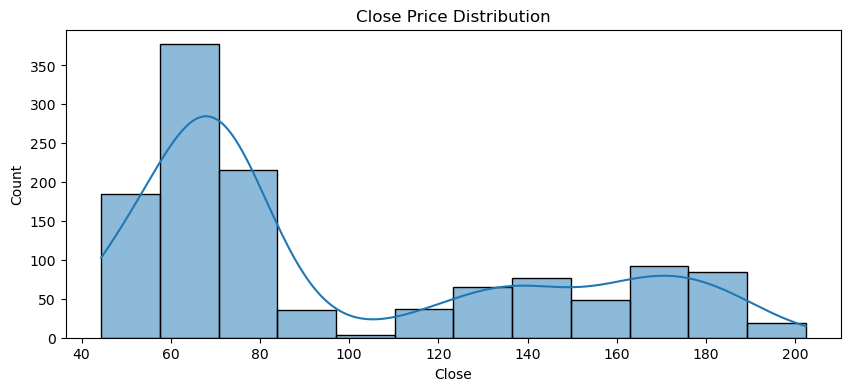

Shapes -> (961, 30, 5) (961,) (218, 30, 5) (218,)


c:\Devs\anaconda_navigator\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0239 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0048 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0037 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0018 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0020 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0029 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 10/20
31/31 ━

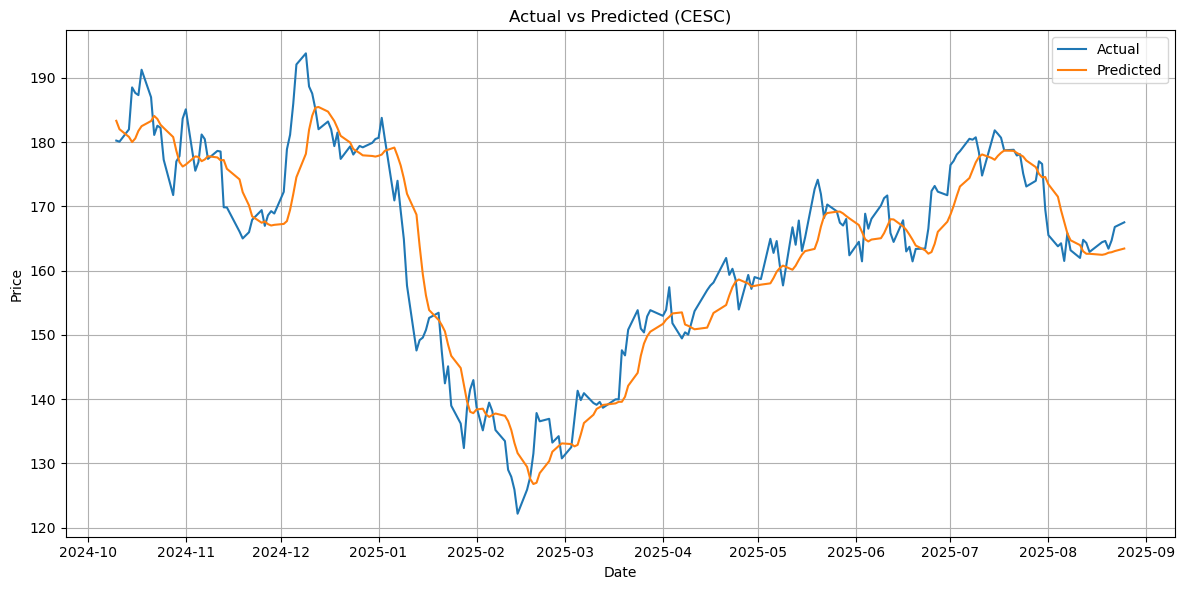

In [ ]:
# Example full pipeline - guarded by a flag to prevent accidental heavy runs
run_full_pipeline = True  # set to True if you want to execute the full pipeline including training

if run_full_pipeline:
    # 1) Load data
    df = load_ticker_data('CESC.NS', period='5y', interval='1d')
    # 2) Quick EDA
    quick_eda(df)
    # 3) Preprocess
    df = round_numeric_columns(df, 2)
    df = handle_volume_skew(df, method='log1p')
    # 4) Scale
    scaled, scaler, feature_cols = scale_features(df)
    feature_count = scaled.shape[1]
    # 5) Train/test split (80/20)
    train_size = int(len(scaled) * 0.8)
    train_scaled = scaled[:train_size]
    test_scaled = scaled[train_size:]
    # 6) Create sequences (lookback from tuning)
    lookback = 30
    X_train, y_train = create_sequences(train_scaled, lookback=lookback, target_col_index=feature_cols.index('Close'))
    X_test, y_test = create_sequences(test_scaled, lookback=lookback, target_col_index=feature_cols.index('Close'))
    print('Shapes ->', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    # 7) Build model
    model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), units=100, dropout=0.4, lr=0.001)
    # 8) Train model (reduce epochs for quick runs)
    history = train_model(model, X_train, y_train, X_val=X_test, y_val=y_test, epochs=20, batch_size=32)
    # 9) Predict and inverse transform
    y_pred_scaled = model.predict(X_test).flatten()
    y_test_inv = inverse_transform_predictions(y_test, scaler, feature_count, target_col_index=feature_cols.index('Close'))
    y_pred_inv = inverse_transform_predictions(y_pred_scaled, scaler, feature_count, target_col_index=feature_cols.index('Close'))
    # 10) Metrics and plot
    metrics = compute_metrics(y_test_inv, y_pred_inv)
    print('Evaluation metrics:', metrics)
    # Dates for plotting
    all_dates = pd.to_datetime(list(df.index))
    test_dates = all_dates[train_size + lookback: train_size + lookback + len(y_test_inv)]
    plot_actual_vs_pred(test_dates, y_test_inv, y_pred_inv, title=f'Actual vs Predicted ({symbol})')

#### Forecast of price

In [ ]:
# Number of days to forecast
future_days = 7

# Start with the last 'lookback' days from your dataset
last_sequence = scaled[-lookback:].copy()
forecast = []

for _ in range(future_days):
    # Reshape for model input
    X_input = np.expand_dims(last_sequence, axis=0)  # shape: (1, lookback, features)
    
    # Predict the next day's closing price
    pred_scaled = model.predict(X_input)
    
    # Store only the predicted closing price (assuming it's the first column in scaler)
    forecast.append(pred_scaled[0, 0])
    
    # Create the next day input row: use predicted close + keep other features same as last day
    next_day = last_sequence[-1].copy()  # last row of features
    next_day[0] = pred_scaled[0, 0]      # replace close price with prediction
    
    # Append new row and keep length
    last_sequence = np.vstack([last_sequence[1:], next_day])

# Convert forecast list to array for inverse scaling
forecast_array = np.zeros((future_days, scaled.shape[1]))  # same feature size
forecast_array[:, 0] = forecast  # set close price predictions

# Inverse transform to get actual close prices
forecast_prices = scaler.inverse_transform(forecast_array)[:, 0]

print("Predicted closing prices for next 14 days:")
print(forecast_prices)

#### Plot the graph for forecast

In [ ]:
# Create x-axis labels
actual_dates = df.index
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_days)
plt.figure(figsize=(12, 8))

# Plot actual prices
# plt.plot(actual_dates, df['Close'], label='Actual Price', color='blue')

# Plot forecasted prices
plt.plot(future_dates, forecast_prices, label='Forecasted Price', color='red', linestyle='--', marker='o')

# Labels and title
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"Actual vs Forecasted Stock Prices (Next {future_days} Days)")
plt.legend()
plt.grid(True)
plt.show()

## 9. Tips & next steps
- Try adding technical indicators (SMA, EMA, RSI, MACD) as additional features.
- Use `keras-tuner` or grid search to automatically find the best hyperparameters.
- Consider ensemble approaches (average of top K models) and stacking for robust predictions.
- Be careful about data leakage: always split before creating sequences or fitting scalers on test data.
